<a href="https://colab.research.google.com/github/Glifoyle/test-repo/blob/master/3_MLP_v5_PyTorch_key_sound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 目的：ニューラルネットワークの「学習」を音データに適用する

### 概要：全結合型ニューラルネットワークMLP（Multi-Layer Perceptron：多層パーセプトロン）の学習により，キーボードの打鍵音からキーボードの種類を分類する

<br>
&copy; 2021-2024 Hiro Kimura
<br>

## ポイント：

-  データには，**[Keyboard sound dataset](https://support.dl.sony.com/blogs-ja/dataset/keyboard-sound-dataset/)** を用いる
-  学習モデルには，**MLP**（Multi-Layer Perceptron）モデルを用いる
-  PyTorchフレームワークの機能（自動微分等）を用いる
-  損失関数には正解ラベルと予測値との**交差エントロピー誤差**を用いる
-  最適値の探索には，勾配降下法（**SGD**：確率的勾配降下法）を用いる



# 実習の準備

1. タイムゾーンを東京に設定する
1. デバイス（CPU / GPU）を設定する
1. Google Driveをマウントする
1. 今回の実習で使用する作業ディレクトリ（フォルダ）を作成する
1. PyTorchフレームワークやライブラリを導入する



In [ ]:
# pythonのバージョン確認
# ! python --version

### タイムゾーンを東京に変更する

In [ ]:
!date

Wed Apr 10 06:46:49 AM UTC 2024


In [ ]:
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Asia/Tokyo /etc/localtime

In [ ]:
!date

Wed Apr 10 03:46:49 PM JST 2024


### CPU / GPU

In [ ]:
import torch

# GPUの設定であればcuda，そうでなければcpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# # 割り当てられたGPUを調べる
# !nvidia-smi

In [ ]:
# # 割り当てられたGPUの機種を調べる
# torch.cuda.get_device_name(0)

## Google Driveをマウントする

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 作業フォルダ（作業ディレクトリ）を作成
import os

chap_dir = "/content/drive/MyDrive/practice/chap_sound"
if not os.path.exists(chap_dir): # ディレクトリが存在していなければ
    # os.mkdir(chap_dir)
    os.makedirs(chap_dir) # ディレクトリを，途中のディレクトリも含めて，作成する

os.chdir(chap_dir) # 今回の作業ディレクトリに移動する
os.getcwd() # 現在の作業ディレクトリを表示する

'/content/drive/MyDrive/practice/chap_sound'

# 「学習」の手順
1. データを準備する
  - データの読み込み
  - データの前処理
  - データの分割
  - データローダの作成
1. モデルを定義する
1. モデルを訓練する
  - 損失関数と最適化手法を設定
  - 訓練を実施
1. 学習済みモデルを性能評価する

# データを準備する


### データセット
- [Keyboard sound dataset](https://support.dl.sony.com/blogs-ja/dataset/keyboard-sound-dataset/) ：
  -  4種類のキーボードの打鍵音のデータセット
    -  メンブレン、パンタグラフ、メカニカル青軸、メカニカル赤軸
  -  データフォーマット：44.1kHz、0.25秒、16bit Wavファイル
  -  データ数：学習用 315ファイル、評価用 100ファイル


## データの読み込み（ネットワークから）
- 手順:
  1. データ格納用ディレクトリの作成
  1. カレントディレクトリにデータをダウンロード
  1. 解凍

In [ ]:
# データを格納するディレクトリを作成する

data_dir = "./dataset"
if not os.path.exists(data_dir): # ディレクトリが存在していなければ
    os.makedirs(data_dir) # ディレクトリを，途中のディレクトリも含めて，作成する

# 現在の作業ディレクトリを確認する
!pwd
!ls -F

/content/drive/MyDrive/practice/chap_sound
dataset/


In [ ]:
# カレントディレクトリにデータをダウンロード（一回だけ）
! wget https://nnabla.org/sample/sample_dataset/keyboard_sound_dataset.zip

--2024-04-10 15:48:33--  https://nnabla.org/sample/sample_dataset/keyboard_sound_dataset.zip
Resolving nnabla.org (nnabla.org)... 99.86.229.76, 99.86.229.88, 99.86.229.55, ...
Connecting to nnabla.org (nnabla.org)|99.86.229.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6749563 (6.4M) [application/zip]
Saving to: ‘keyboard_sound_dataset.zip’

keyboard_sound_data 100%[===================>]   6.44M  12.4MB/s    in 0.5s    

2024-04-10 15:48:34 (12.4 MB/s) - ‘keyboard_sound_dataset.zip’ saved [6749563/6749563]



In [ ]:
# ファイルを確認する
!ls -F

dataset/  keyboard_sound_dataset.zip


In [ ]:
# ./dataset 内に解凍する（一回だけ）
!unzip -d ./dataset keyboard_sound_dataset.zip

Archive:  keyboard_sound_dataset.zip
  inflating: ./dataset/blue/1033816.wav  
  inflating: ./dataset/blue/1076009.wav  
  inflating: ./dataset/blue/1119084.wav  
  inflating: ./dataset/blue/1166246.wav  
  inflating: ./dataset/blue/117431.wav  
  inflating: ./dataset/blue/1207955.wav  
  inflating: ./dataset/blue/1248893.wav  
  inflating: ./dataset/blue/1288306.wav  
  inflating: ./dataset/blue/1288316.wav  
  inflating: ./dataset/blue/1330195.wav  
  inflating: ./dataset/blue/1370659.wav  
  inflating: ./dataset/blue/1410238.wav  
  inflating: ./dataset/blue/1451054.wav  
  inflating: ./dataset/blue/1497660.wav  
  inflating: ./dataset/blue/153078.wav  
  inflating: ./dataset/blue/1543050.wav  
  inflating: ./dataset/blue/1543053.wav  
  inflating: ./dataset/blue/1543106.wav  
  inflating: ./dataset/blue/1591646.wav  
  inflating: ./dataset/blue/1591710.wav  
  inflating: ./dataset/blue/1639425.wav  
  inflating: ./dataset/blue/1639426.wav  
  inflating: ./dataset/blue/1685214.wav  

In [ ]:
# 解凍したファイルを確認する
!ls -F ./dataset

blue/	 membrane/    red/			   wav_keyboard_sound_train.csv
LICENSE  pantograph/  wav_keyboard_sound_test.csv


### 音声データを音として確認する

In [ ]:
from IPython.display import Audio

各カテゴリーの最初のファイル:
```
./dataset/blue/1033816.wav  
./dataset/membrane/1028345.wav  
./dataset/pantograph/1010562.wav  
./dataset/red/1012693.wav  
```

In [ ]:
# 音声ファイルを再生する（メカニカル青軸）

file_path1 = "./dataset/blue/1033816.wav"
Audio(file_path1)

In [ ]:
# 音声ファイルを再生する（メンブレン）

file_path2 = "./dataset/membrane/1028345.wav"
Audio(file_path2)


In [ ]:
# 音声ファイルを再生する（パンタグラフ）

file_path3 = "./dataset/pantograph/1010562.wav"
Audio(file_path3)

In [ ]:
# 音声ファイルを再生する（メカニカル赤軸）

file_path4 = "./dataset/red/1012693.wav"
Audio(file_path4)

### 音声データを波形として確認する

In [ ]:
import soundfile as sf
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
#
data, samplerate =sf.read(file_path1)
print(f"Data shape: {data.shape}, Sample Rate: {samplerate}")

Data shape: (11025,), Sample Rate: 44100


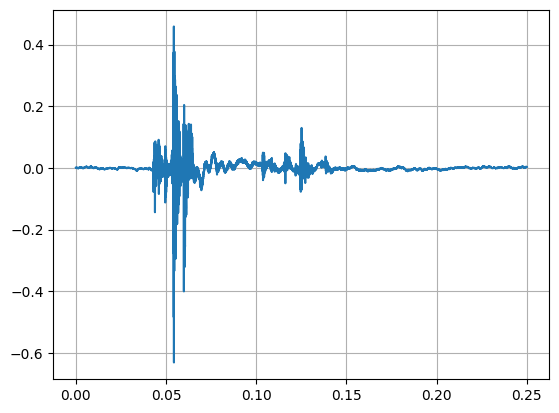

In [ ]:
t = np.arange(0, len(data)) / samplerate
plt.plot(t, data)
plt.grid(axis="both") # グリッド表示
plt.show()

In [ ]:
#
data, samplerate =sf.read(file_path2)
print(f"Data shape: {data.shape}, Sample Rate: {samplerate}")

Data shape: (11025,), Sample Rate: 44100


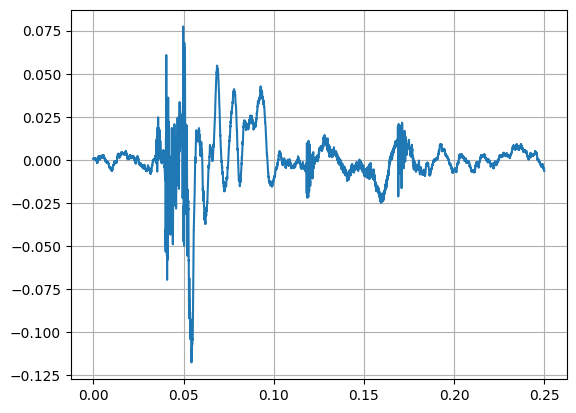

In [ ]:
t = np.arange(0, len(data)) / samplerate
plt.plot(t, data)
plt.grid(axis="both") # グリッド表示
plt.show()

In [ ]:
#
data, samplerate =sf.read(file_path3)
print(f"Data shape: {data.shape}, Sample Rate: {samplerate}")

Data shape: (11025,), Sample Rate: 44100


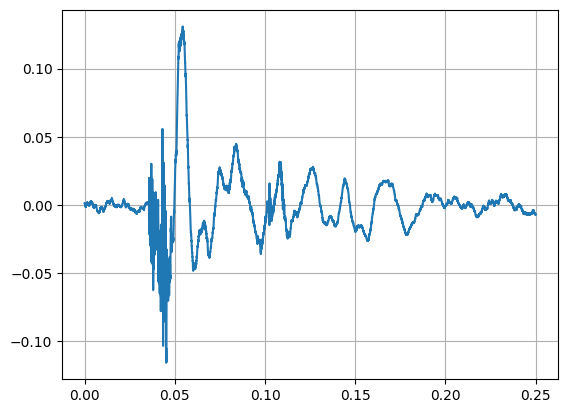

In [ ]:
t = np.arange(0, len(data)) / samplerate
plt.plot(t, data)
plt.grid(axis="both") # グリッド表示
plt.show()

In [ ]:
#
data, samplerate =sf.read(file_path4)
print(f"Data shape: {data.shape}, Sample Rate: {samplerate}")

Data shape: (11025,), Sample Rate: 44100


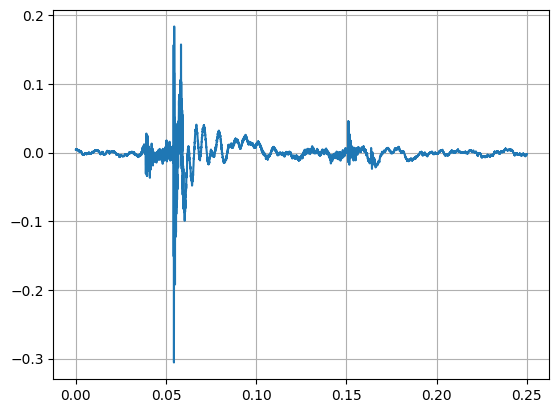

In [ ]:
t = np.arange(0, len(data)) / samplerate
plt.plot(t, data)
plt.grid(axis="both") # グリッド表示
plt.show()

# データセットの作成

### データ分割
- Keyboard sound dataset は訓練用とテスト用に**2分割**されている
  - 訓練用 ： 315件
  - テスト用 ： 100件

- 訓練用とテスト用のファイル名はcsvファイルに定義されている
  - 訓練用 ： wav_keyboard_sound_train.csv
  - テスト用 ： wav_keyboard_sound_test.csv
<br>

**<注意>**<br>
**（カンニング禁止）**：一度でも訓練で使用したデータはテストに使ってはいけない

In [ ]:
# ライブラリ
import torch

# 乱数シードを固定して再現性を確保する
torch.manual_seed(24)

### データ分割定義ファイルを確認する

In [ ]:
import pandas as pd

In [ ]:
# データ定義ファイルを読み込む
train_csv = "./dataset/wav_keyboard_sound_train.csv"
test_csv = "./dataset/wav_keyboard_sound_test.csv"
# df = pd.read_csv(train_csv, skiprows=1) # 1行目のラベルをスキップ
# df = pd.read_csv(test_csv, skiprows=1) # 1行目のラベルをスキップ
# df = pd.read_csv(train_csv) #
df = pd.read_csv(test_csv) #

In [ ]:
# print(f"train data: {df.shape}")
# print(f"test data: {df.shape}")

In [ ]:
print(df.shape)
print(df.shape[0])
print(df.shape[1])

(100, 2)
100
2


In [ ]:
print(df.head())

                          x  y
0         .\red\2217623.wav  1
1         .\red\2520235.wav  1
2     .\membrane\890535.wav  2
3  .\pantograph\2792851.wav  3
4    .\membrane\1982680.wav  2


In [ ]:
for i, row in df.iterrows():
  print(f"file name: {row['x']}, \tlabel: {row['y']}")

file name: .\red\2217623.wav, 	label: 1
file name: .\red\2520235.wav, 	label: 1
file name: .\membrane\890535.wav, 	label: 2
file name: .\pantograph\2792851.wav, 	label: 3
file name: .\membrane\1982680.wav, 	label: 2
file name: .\blue\1815496.wav, 	label: 0
file name: .\pantograph\3148524.wav, 	label: 3
file name: .\pantograph\432909.wav, 	label: 3
file name: .\pantograph\159783.wav, 	label: 3
file name: .\red\3430149.wav, 	label: 1
file name: .\blue\1207955.wav, 	label: 0
file name: .\red\1615699.wav, 	label: 1
file name: .\red\4165451.wav, 	label: 1
file name: .\pantograph\1933958.wav, 	label: 3
file name: .\blue\1033816.wav, 	label: 0
file name: .\red\2783251.wav, 	label: 1
file name: .\blue\1288306.wav, 	label: 0
file name: .\blue\1076009.wav, 	label: 0
file name: .\blue\2691615.wav, 	label: 0
file name: .\red\4698113.wav, 	label: 1
file name: .\blue\1639426.wav, 	label: 0
file name: .\red\2051702.wav, 	label: 1
file name: .\pantograph\2848305.wav, 	label: 3
file name: .\blue\168521

### データセット作成クラス

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import os

class SoundDataset(Dataset):
    def __init__(self, mode="train"): # 引数：csvファイル名
        self.data_dir = "./dataset/"
        self.train_csv = "./dataset/wav_keyboard_sound_train.csv"
        self.test_csv = "./dataset/wav_keyboard_sound_test.csv"

        # データ前処理後のデータ（テンソル型）
        self.x, self.t = self.preprocessing(mode)

    def __len__(self):
        return len(self.x) # データ件数を返す

    def __getitem__(self, idx):
        x = self.x[idx]
        t = self.t[idx]
        return x, t

    def preprocessing(self, mode):
        # データを読み込んで、テンソルに変換するなどの前処理を行う
        if mode == "train":
            df = pd.read_csv(self.train_csv)
        elif mode == "test":
            df = pd.read_csv(self.test_csv)

        # データセット
        xs, ts = [], []

        for i, row in df.iterrows():
            # データの読み込み
            file_name = row['x'] # 1列目
            label = row['y'] # 2列目

            # ファイルを開いてデータを読み込む
            # file_path = data_dir+file_name[1:] # これだと/と\\が混在する
            file_path = os.path.join(data_dir, file_name[1:]) #file_name[0]には.が入っているので除く
            file_path = file_path.replace("\\", "/")  # バックスラッシュをスラッシュに変換
            data, samplerate =sf.read(file_path)

            # 結果を追加
            xs.append(data) # 音声データ
            ts.append(label) # ラベル
            # --- 一人分の処理はここまで

        # 処理の高速化のために，numpy arrayに変換してからtensorに変換する
        xs = torch.tensor(np.array(xs), dtype=torch.float32) # 音声データ
        ts = torch.tensor(np.array(ts), dtype=torch.int64) # 4クラス分類用ラベル：0, 1, 2, 3

        return xs, ts


### データセットとデータローダを作成する

In [ ]:
# バッチサイズ
batch_size = 32

# 訓練データセットの作成
train_ds = SoundDataset('train')
# データローダの作成
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True) # 訓練用はshuffleする


In [ ]:
# テストデータセットの作成
test_ds = SoundDataset('test')
# データローダの作成
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False) # テスト用はshuffleしないい

# モデルを定義する

- 課題設定：
  - 説明変数：入力データは，11,025個（0.25秒を44.1kHzで）
  - 目的変数：出力値は，4個（4クラスの確率）
- ニューラルネットワークモデル（MLP）
  - 入力層ノード数：11,025個（仕様上固定）
  - 出力層ノード数：4個（仕様上固定）
  - 隠れ層は1層：入力：1,024ノード，出力：128ノード（任意数）
  - 活性化関数：
    - 隠れ層：ReLU
    - 最終出力層：softmax関数


In [ ]:
# -----------------
# 3L-MLP
# -----------------
import torch
from torch import nn
import torch.nn.functional as F

class SoundClassifier_MLP(nn.Module):

  def __init__(self):
    super(SoundClassifier_MLP, self).__init__()

    # SoundDataset has the shape of (channels, data) :
    self.layer_1 = nn.Linear(11025, 1024)      # 入力層入力：11025，中間層入力：1024
    self.layer_2 = nn.Linear(1024, 128)     # 中間層入力：1024，中間層出力：128
    self.layer_3 = nn.Linear(128, 4)       # 出力層入力：128，出力：4

    # # [提出課題]では以下の構造とする
    # # SoundDataset has the shape of (channels, data) :
    # self.layer_1 = nn.Linear(11025, 2048)      # 入力層入力：11025，中間層入力：2048
    # self.layer_2 = nn.Linear(2048, 64)     # 中間層入力：2048，中間層出力：256
    # self.layer_3 = nn.Linear(64, 4)       # 出力層入力：256，出力：4

  def forward(self, x):
    # 入力はバッチサイズ分の音声データ
    # batch_size, channels, height, width = x.size()
    # batch_size, channels, width = x.size()
    batch_size, width = x.size()

    # b: batch（バッチ長）, c: channel, w: width（横）
    x = x.view(batch_size, -1) # (32, 11025)

    # layer 1
    x = self.layer_1(x)
    x = F.relu(x) # 活性化関数

    # layer 2
    x = self.layer_2(x)
    x = F.relu(x) # 活性化関数

    # layer 3
    x = self.layer_3(x)
    x = F.softmax(x, dim=1) # 活性化関数
    # probability distribution over labels => log_softmax()
    # x = F.log_softmax(x, dim=1)

    return x

# 訓練の準備をする
### 損失関数と最適化手法を設定する
- 損失関数は，交差エントロピー誤差（$loss=-\sum_{k}^{n} t_{k}\log y_k$）
- 最適化手法は，Adamで最小化

### 損失関数（交差エントロピー誤差）
- 教師ラベル$t$は **one-hotベクトル**（一つの要素だけが1で，他の要素は全て0のベクトル）で表現する<br>
例えば，$5$であれば，0から始まるので6番目の要素だけが1で，$$t = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]$$<br>
- 予測結果 $y$ は，softmax関数を施した$0～1$の実数値を要素とするベクトルで表現する<br>
softmax関数を施した出力の合計は$1$になる（つまり各要素は確率とみなすことができる）<br>
例えば，$$y = [0.01, 0.0, 0.08, 0.02, 0.0, 0.6, 0.18, 0.04, 0.02, 0.05]$$
- 損失関数には交差エントロピー誤差を用いる<br>
$$ loss = -\sum_{n=1}^n t_n\log y_n $$
ここで，$log$は自然対数を表す．交差エントロピー誤差は，結果的に $t$ が1の要素の自然対数値だけになる．
例えば，上記の場合には，教師ラベルが$1$の6番目の項だけが残るので，$ -1*\log 0.6 = 0.51$ と計算できる



In [ ]:
# 学習モデルの初期化

model = SoundClassifier_MLP() # モデルパラメータ値の初期化
# model = model.to(device) # モデルのパラメータ値を演算デバイスに送る

In [ ]:
# 損失関数（交差エントロピー誤差）
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

In [ ]:
# # 最適化手法（SGD）
# from torch import optim

# # 学習率 lr は試行錯誤する必要がある．
# eta = 0.01
# optimizer = optim.SGD(model.parameters(), lr=eta) # SGD

In [ ]:
# 最適化手法（Adam）
from torch import optim

# 学習率 lr は試行錯誤する必要がある．
eta = 0.001
optimizer = optim.Adam(model.parameters(), lr=eta) # Adam

## 訓練と検証用の関数

- 作業フォルダに **train_valid.py** が存在することを確認する
    - 存在しない場合は，パソコンからドラッグ&ドロップする
    - パソコンにも存在しない場合は，Moodleからダウンロードする


In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
# 作業フォルダを確認する
!ls -F

dataset/  keyboard_sound_dataset.zip  train_valid.py


In [ ]:
# 関数を読み込む
from train_valid import train, valid

# # 訓練用の関数（1エポックの処理）を定義
# def train(model, criterion, optimizer, train_loader, device, scheduler=None):
#       return epoch_loss, epoch_acc # 1エポックの1データ当たりのロスと正解率

# # 検証用の関数（1エポックの処理）を定義
# def valid(model, criterion, optimizer, valtest_loader, device):
#       return val_loss, val_acc # 1エポックの1データ当たりのロスと正解率


# 訓練を実施する

In [ ]:
# 訓練を実施する

# 訓練の長さ
EPOCHS=20

# # 演算装置
# device = "cpu"

# 訓練と検証の状況を記録する空の入れ物
train_loss_list = [] # 訓練ロス
train_acc_list = [] # 訓練の正解率
val_loss_list = [] # 検証ロス
val_acc_list = [] # 検証の正解率

for epoch in range(EPOCHS):
    # エポックの処理
    # 訓練
    loss, acc = train(model, criterion, optimizer, train_loader, device)

    # 検証
    val_loss, val_acc = valid(model, criterion, optimizer, test_loader, device)

    print('epoch %d, train_loss: %.2f train_acc: %.2f val_loss: %.2f val_acc: %.2f' % (epoch, loss, acc, val_loss, val_acc))

    # 訓練と検証の状況を記録
    train_loss_list.append(loss)
    train_acc_list.append(acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, train_loss: 1.28 train_acc: 0.61 val_loss: 1.10 val_acc: 0.71
epoch 1, train_loss: 1.03 train_acc: 0.79 val_loss: 0.97 val_acc: 0.76
epoch 2, train_loss: 0.87 train_acc: 0.93 val_loss: 0.88 val_acc: 0.88
epoch 3, train_loss: 0.80 train_acc: 0.97 val_loss: 0.87 val_acc: 0.93
epoch 4, train_loss: 0.77 train_acc: 0.99 val_loss: 0.89 val_acc: 0.86
epoch 5, train_loss: 0.76 train_acc: 0.99 val_loss: 0.87 val_acc: 0.92
epoch 6, train_loss: 0.75 train_acc: 0.99 val_loss: 0.85 val_acc: 0.91
epoch 7, train_loss: 0.75 train_acc: 0.99 val_loss: 0.86 val_acc: 0.91
epoch 8, train_loss: 0.75 train_acc: 0.99 val_loss: 0.87 val_acc: 0.92
epoch 9, train_loss: 0.75 train_acc: 0.99 val_loss: 0.87 val_acc: 0.92
epoch 10, train_loss: 0.75 train_acc: 0.99 val_loss: 0.87 val_acc: 0.92
epoch 11, train_loss: 0.75 train_acc: 1.00 val_loss: 0.87 val_acc: 0.86
epoch 12, train_loss: 0.75 train_acc: 1.00 val_loss: 0.87 val_acc: 0.86
epoch 13, train_loss: 0.75 train_acc: 1.00 val_loss: 0.87 val_acc: 0.86
ep

## 訓練の様子をグラフ表示

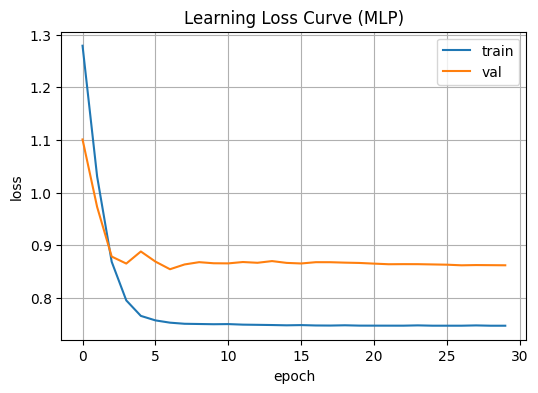

In [ ]:
# 損失が減少していく様子をグラフ表示する
%matplotlib inline
from matplotlib import pyplot as plt

# 図の大きさをインチ単位で指定する
plt.figure(figsize=(6, 4))

plt.title('Learning Loss Curve (MLP)') # タイトル
plt.plot(train_loss_list, label='train') # 訓練ロスグラフ
plt.plot(val_loss_list, label='val') # 検証ロスグラフ
plt.legend() # 凡例
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(axis="both") # グリッド表示

plt.show()

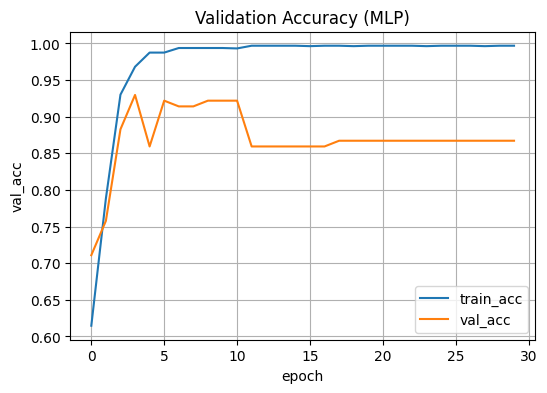

val正解率：0.867


In [ ]:
# 正解率が上昇していく様子をグラフ表示する

# 図の大きさをインチ単位で指定する
plt.figure(figsize=(6, 4))

plt.title('Validation Accuracy (MLP)') # タイトル
plt.plot(train_acc_list, label="train_acc")
plt.plot(val_acc_list, label='val_acc')
plt.legend() # 凡例
plt.xlabel('epoch')
plt.ylabel('val_acc')
plt.grid(axis="both") # グリッド表示

plt.show()
print(f'val正解率：{val_acc_list[-1]:.3f}')

### 訓練済みモデルを保存する


In [ ]:
# 現在の作業ディレクトリに訓練済みモデルのパラメータ値を保存する

torch.save(model.state_dict(), './key_sound.pkl')

# 学習済みモデルを評価する

### テストデータでモデルの予測性能を評価する

In [ ]:
# テストを実施する

# テスト
test_loss, test_acc = valid(model, criterion, optimizer, test_loader, device)
print('test_loss: %.2f test_acc: %.2f' % (test_loss, test_acc))


test_loss: 0.86 test_acc: 0.87


# まとめ
- AI手法を適用することで，キーボードのクリック音から，キーボードの種類を判別することができた
- MLP（Multi-Layer Perseptron）を用いた全結合型ニューラルネットワークモデルを構築した
- MLPモデルでキーボードを精度良く（91%程度の精度で）分類できることが理解できた
- 音声データを用いても，数値データや画像データと同様に分類できることが理解できた
- 音声データに関しても，数値データや画像データと同様の「学習」手続きが適用できることが理解できた
  1. データの準備
    - csvファイルによる訓練データと教師ラベルの定義
    - データの前処理（ラベリングやテンソル変換）
    - データ分割
    - データローダの作成
  1. モデルの定義
  1. モデルの訓練と検証
  1. 学習済みモデルの性能評価


# [提出課題]

- 以下の手順に従って，隠れ層の入力ノード数を2048，出力ノード数を64にした時の，予測精度を確認する

  1. Soundデータのダウンロードのセルと，回答のセルを以下のようにコメントにする
    ```
    # # カレントディレクトリにデータをダウンロード（一回だけ）
    # ! wget https://nnabla.org/sample/sample_dataset/keyboard_sound_dataset.zip
    ```
    ```
    # # ./dataset 内に解凍する（一回だけ）
    # !unzip -d ./dataset keyboard_sound_dataset.zip
    ```

  1. MLPのネットワーク構成を，以下のように修正する
    ```
    # SoundDataset has the shape of (channels, data) :
    self.layer_1 = nn.Linear(11025, 2048)      # 入力層入力：11025，中間層入力：2048
    self.layer_2 = nn.Linear(2048, 64)     # 中間層入力：2048，中間層出力：64
    self.layer_3 = nn.Linear(64, 4)       # 出力層入力：64，出力：4
    ```
  1. 以下の手順でプログラムを再実行する
    1. メニューバーの，ランタイム ／ ランタイムを再起動
    1. メニューバーの，ランタイム ／ すべてのセルを実行

  1. テストデータでモデルの予測性能を評価する
    1. test_loss の値を、小数第3位を四捨五入して、小数第2位までで答えよ
    1. test_acc の値を、小数第3位を四捨五入して、小数第2位までで答えよ

<!--
# 発展課題
- 各種のハイパーパラメータを変更して性能が変わるか確認する
  1. エボック数を増やしてみる
  1. 最適化手法のetaを一桁減らしてみる
- MPLモデルを変更して性能が変わるか確認する
  1. 隠れ層（中間層）のノード数を2倍にしていみる
  1. 隠れ層（中間層）の層数を2倍にしていみる


ハイパーパラメータやモデルを変更した実験の仕方:
1. 該当箇所を修正
1. 上部メニューの，ランタイム / ランタイムを再起動
1. ランタイム / すべてのセルを実行
-->

<!--
1. MLPモデルの最終段の出力層の活性化関数を変更して実行し，結果の違いをグラフで確認する
 - F.log_softmax(x, dim=1)
 - F.softmax(x, dim=1)
 - なし（コメントアウト）

1. breastcancer.xlsxを読み込んで，悪性と良性を分類する．分類性能をchap4のロジスティク回帰の結果と比較する
  - ファイルからデータを読み込んで，スケール変換し，データ分割し，データローダを作成するところまでは，chap4と同様にする
  - MLPモデルを修正する
    - 入力ノード数が，breastcancerの説明変数の数と同じ30個
    - 出力ノード数が，悪性と良性の2クラスなので2個
-->